In [1]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2,r_regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from keras.optimizer_v2.adam import Adam

In [2]:
data=yf.download('0005.hk')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,111.0,111.5,107.50,108.0,55.387085,3908164
2000-01-04,106.0,106.5,105.00,106.0,54.361393,6895378
2000-01-05,101.0,102.0,99.50,100.5,51.540764,14657098
2000-01-06,101.0,102.0,96.25,97.0,49.745800,10632084
2000-01-07,98.5,101.0,97.50,100.5,51.540764,8368286


In [3]:
data['Prediction']=data['Close'].shift(-1)
data.drop('Adj Close',1,inplace=True)
data.head()

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2000-01-03,111.0,111.5,107.50,108.0,3908164,106.0
2000-01-04,106.0,106.5,105.00,106.0,6895378,100.5
2000-01-05,101.0,102.0,99.50,100.5,14657098,97.0
2000-01-06,101.0,102.0,96.25,97.0,10632084,100.5
2000-01-07,98.5,101.0,97.50,100.5,8368286,100.0


In [4]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MTM6']=talib.MOM(data['Close'],timeperiod=6)
data['MTM12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)

In [5]:
data.dropna(inplace=True)
newData=data[-5:]
data=data[:-5]
data

,Open,High,Low,Close,Volume,Prediction,6day MA,12day MA,RSI,%R5,%R10,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC6,OSC12
Date,,,,,,,,,,,,,,,,,,,
2000-02-18,93.000000,93.500000,90.500000,91.250000,10116832,89.500000,90.375000,90.479167,50.204183,-37.500000,-37.500000,1.500000,-0.750000,91.053042,93.063655,-2.141415,3.000000,3.011926,-12.789952
2000-02-21,90.000000,91.000000,88.500000,89.500000,8839331,88.750000,90.250000,90.312500,42.389337,-59.375000,-59.375000,-0.750000,-2.000000,90.814112,92.799680,-2.096247,2.750000,-15.435632,-20.813717
2000-02-22,88.750000,89.000000,88.000000,88.750000,11567491,88.250000,90.458333,90.104167,39.328385,-88.000000,-68.750000,1.250000,-2.500000,90.496557,92.499704,-2.096799,1.500000,-22.567136,-24.079465
2000-02-23,87.750000,88.750000,87.500000,88.250000,15418845,90.250000,90.541667,89.854167,37.237017,-88.888889,-75.000000,0.500000,-3.000000,90.150933,92.184911,-2.113222,1.250000,-27.461036,-26.290292
2000-02-24,89.000000,90.500000,88.750000,90.250000,8222217,89.500000,90.166667,89.958333,49.715579,-54.166667,-50.000000,-2.250000,1.250000,90.166174,92.041584,-1.942463,2.250000,2.206474,-12.051833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10,45.099998,45.400002,44.950001,45.200001,6090109,45.099998,45.225000,44.670833,53.464759,-44.117627,-20.000000,1.200001,-0.899998,45.030425,45.087544,-0.057119,0.450001,8.957680,2.319515
2021-12-13,45.200001,45.250000,44.500000,45.099998,10861423,44.500000,45.266666,44.583333,51.304189,-54.838884,-22.666728,0.250000,-1.050003,45.041129,45.088466,-0.047338,0.750000,3.544557,0.128164
2021-12-14,44.150002,44.599998,44.150002,44.500000,7998591,44.950001,45.208333,44.595833,39.991715,-80.555632,-49.152556,-0.349998,0.150002,44.957878,45.044876,-0.086998,0.949997,-23.734975,-12.182049


In [6]:
# Feature extraction
X=data.drop('Prediction',1)
Y=data['Prediction'].values.reshape(-1,1)

In [7]:
#no of features
nof_list=np.arange(1,16)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y.ravel(), test_size = 0.3, random_state = 0)
    model = RandomForestRegressor()
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.997869


In [8]:
cols = list(X.columns)
model = LinearRegression()
rfe = RFE(model,n_features_to_select=nof)
fit = rfe.fit(X, Y.ravel())
temp = pd.Series(fit.support_,index = cols)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Num Features: 12
Selected Features: [False  True  True  True False  True  True  True False False False  True
  True  True  True  True  True False]
Feature Ranking: [3 1 1 1 7 1 1 1 4 6 2 1 1 1 1 1 1 5]
Index(['High', 'Low', 'Close', '6day MA', '12day MA', 'RSI', 'MTM12', 'EMA12',
       'EMA26', 'MACD', 'TR', 'OSC6'],
      dtype='object')


In [9]:
X.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', '6day MA', '12day MA', 'RSI',
       '%R5', '%R10', 'MTM6', 'MTM12', 'EMA12', 'EMA26', 'MACD', 'TR', 'OSC6',
       'OSC12'],
      dtype='object')

In [10]:
data_selected=data[selected_features_rfe]

In [11]:
data_selected['Prediction']=data['Prediction']
data_selected

<ipython-input-11-90499717273d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Prediction']=data['Prediction']


,High,Low,Close,6day MA,12day MA,RSI,MTM12,EMA12,EMA26,MACD,TR,OSC6,Prediction
Date,,,,,,,,,,,,,
2000-02-18,93.500000,90.500000,91.250000,90.375000,90.479167,50.204183,-0.750000,91.053042,93.063655,-2.141415,3.000000,3.011926,89.500000
2000-02-21,91.000000,88.500000,89.500000,90.250000,90.312500,42.389337,-2.000000,90.814112,92.799680,-2.096247,2.750000,-15.435632,88.750000
2000-02-22,89.000000,88.000000,88.750000,90.458333,90.104167,39.328385,-2.500000,90.496557,92.499704,-2.096799,1.500000,-22.567136,88.250000
2000-02-23,88.750000,87.500000,88.250000,90.541667,89.854167,37.237017,-3.000000,90.150933,92.184911,-2.113222,1.250000,-27.461036,90.250000
2000-02-24,90.500000,88.750000,90.250000,90.166667,89.958333,49.715579,1.250000,90.166174,92.041584,-1.942463,2.250000,2.206474,89.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10,45.400002,44.950001,45.200001,45.225000,44.670833,53.464759,-0.899998,45.030425,45.087544,-0.057119,0.450001,8.957680,45.099998
2021-12-13,45.250000,44.500000,45.099998,45.266666,44.583333,51.304189,-1.050003,45.041129,45.088466,-0.047338,0.750000,3.544557,44.500000
2021-12-14,44.599998,44.150002,44.500000,45.208333,44.595833,39.991715,0.150002,44.957878,45.044876,-0.086998,0.949997,-23.734975,44.950001


In [12]:
regr=RandomForestRegressor()
regr.fit(X_train,y_train)

RandomForestRegressor()

In [13]:
y_pred=regr.predict(X_test)

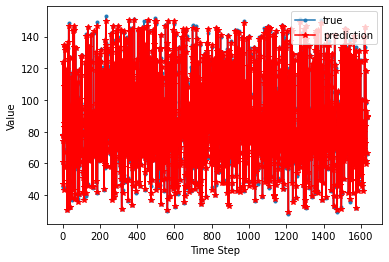

In [14]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test,y_pred)*100

1.11322355462679

                 Open       High        Low      Close    Volume  Prediction  \
Date                                                                           
2021-12-17  46.299999  46.750000  46.049999  46.400002  39799001   45.500000   
2021-12-20  45.799999  46.000000  45.349998  45.500000  16771986   45.450001   
2021-12-21  45.700001  45.750000  45.200001  45.450001  12301373   45.700001   
2021-12-22  45.599998  45.750000  45.299999  45.700001   8541568   46.200001   
2021-12-23  46.299999  46.299999  45.900002  46.200001   9198207   46.450001   

              6day MA   12day MA        RSI        %R5       %R10      MTM6  \
Date                                                                          
2021-12-17  45.216667  45.120833  70.328827 -13.461488 -13.461488  1.100002   
2021-12-20  45.266667  45.245833  53.975526 -48.076951 -48.076951  0.299999   
2021-12-21  45.325001  45.295834  53.174145 -53.061177 -50.000000  0.350002   
2021-12-22  45.525001  45.366667  56.906459 

/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


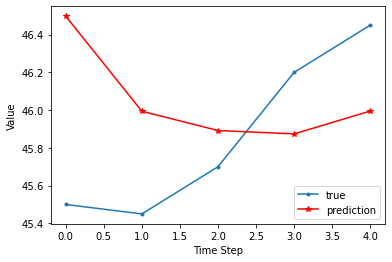

In [16]:
print(newData)
x_unseen=newData.drop('Prediction',1).values
y_unseen=newData['Prediction'].values
unseend_pred = regr.predict(x_unseen)
plt.plot(y_unseen, marker='.', label="true")
plt.plot(unseend_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();